In [14]:
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from fastkde import fastkde
from sklearn.ensemble import RandomForestClassifier


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### This code should not be run again. It was used to subset the original data.

In [2]:
# importing train data
train = pd.read_csv('data/train.csv')
train

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,527987,0,2,1,8,0,0,0,0,0,...,3,1,1,7,1,1,0,1,0,0
1,47519,0,3,1,3,0,0,1,0,0,...,3,2,3,5,0,0,1,1,1,1
2,938513,0,1,1,1,0,0,1,0,0,...,1,1,1,4,0,1,1,0,0,1
3,279774,0,0,1,2,0,0,1,0,0,...,6,0,5,3,0,1,1,0,0,0
4,232653,0,3,1,2,1,0,0,1,0,...,4,0,5,11,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59516,1207113,1,1,1,7,0,4,0,0,1,...,3,1,1,9,0,0,1,0,1,0
59517,1212728,1,0,1,5,0,0,0,1,0,...,6,2,1,2,0,1,1,0,0,0
59518,757821,1,3,1,7,0,1,1,0,0,...,3,1,3,8,0,0,0,1,0,0
59519,875118,1,0,3,5,1,0,0,1,0,...,7,2,4,6,0,1,1,0,0,0


In [3]:
##subsetting the train data to only be 10% of each class and saving it over the original data
#subset_train = train.groupby('target').sample(frac=0.1)
#subset_train['target'].value_counts()
#subset_train.to_csv('data/train.csv', index=False)
#subset_train

### Setting Up
Loading data, setting X and y, and defining a cross validation function that can be used for all methods.

In [15]:
train = pd.read_csv('data/train.csv', header = 0)

x = train.drop(columns=['target', 'id'])
y = train['target']

In [21]:
def crossvalidate(kf, x, y, model):
    cm_list = []
    accuracy = []
    recall = []
    for train_index, test_index in kf.split(x, y):
        xtrain, xtest = x[train_index], x[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        model.fit(xtrain, ytrain)
        y_pred = model.predict(xtest)
        accuracy.append(accuracy_score(ytest, y_pred))
        recall.append(recall_score(ytest, y_pred, average = 'binary'))
        cm_list.append(confusion_matrix(ytest, y_pred))
    return cm_list, accuracy, recall

### Synthetic Minority Oversampling

In [6]:
oversample = SMOTE()
x_sampled, y_sampled = oversample.fit_resample(x, y)
counter = Counter(y_sampled)

In [7]:
model = KNeighborsClassifier()
kf = StratifiedKFold(n_splits = 5)
scaler = StandardScaler()
x_sampled = scaler.fit_transform(x_sampled)
results, accuracy, recall = crossvalidate(kf, x_sampled, y_sampled, model)

In [8]:
accuracy, recall, results

([0.8852709123403514,
  0.8911555729915871,
  0.8881042674687242,
  0.8934658471731833,
  0.8900610287707061],
 [np.float64(0.997384481255449),
  np.float64(1.0),
  np.float64(0.9999128236422282),
  np.float64(1.0),
  np.float64(1.0)],
 [array([[ 8869,  2602],
         [   30, 11440]]),
  array([[ 8974,  2497],
         [    0, 11470]]),
  array([[ 8904,  2566],
         [    1, 11470]]),
  array([[ 9026,  2444],
         [    0, 11471]]),
  array([[ 8948,  2522],
         [    0, 11470]])])

### ADASYN with FastKDE

In [9]:
# converting X and y to numpy arrays
X = np.array(x) 
y = np.array(y) 

# applying FastKDE to the feature data to smooth and estimate the density
num_points = 257  # setting number of points for KDE
var_names = [f'feature_{i}' for i in range(X.shape[1])]  # assigning names to each feature

# calculating the pdf for each feature in the data, the density estimation for each feature is stored in kde_result
kde_result = {}
for i in range(X.shape[1]):
    kde_result[f'feature_{i}'] = fastkde.pdf(X[:, i], var_names=[var_names[i]], num_points=num_points)

# using ADASYN to generate synthetic data to balance the data
adasyn = ADASYN(sampling_strategy='minority', n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# splitting the resampled data using stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True)

# creating the RandomForest model
model = RandomForestClassifier()  # performs better than KNN

# calling the crossvalidate function with the resampled data
cm_list, accuracy, recall = crossvalidate(skf, X_resampled, y_resampled, model)

# printing average scores across all folds
print("Average Accuracy: ", np.mean(accuracy))
print("Average Recall: ", np.mean(recall))
print("Confusion Matrix (average across folds):\n", np.mean(cm_list, axis=0))


Average Accuracy:  0.9808586369029308
Average Recall:  0.9614056424597661
Confusion Matrix (average across folds):
 [[11470.4     0. ]
 [  435.6 10851. ]]


### Normalizing Flows

In [4]:
! pip install pkbar

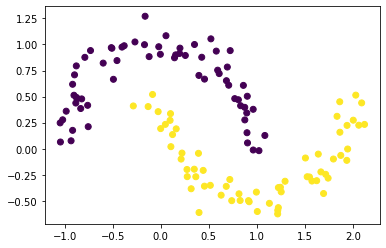

In [5]:
# Basic imports

import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim
import numpy as np
from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet
import pkbar

x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1], c=y)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_layers = 5
base_dist = ConditionalDiagonalNormal(shape=[2],
                                      context_encoder=nn.Linear(1, 4))

transforms = []
for _ in range(num_layers):
    # Permutations
    transforms.append(ReversePermutation(features=2))
    # Affine transformation
    # Notice this is affine, but also autoregressive
    # Autoregressive refers to the way the NN(x_2) functions - not important at this time
    # See slides for reference on affine functions.
    transforms.append(MaskedAffineAutoregressiveTransform(features=2,
                                                          hidden_features=4,
                                                          context_features=1))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)
optimizer = optim.Adam(flow.parameters())

In [12]:
num_iter = 5000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32, device=device)
    y = torch.tensor(y, dtype=torch.float32, device=device).reshape(-1, 1)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()

    if (i + 1) % 500 == 0:
        print(f'Penalty: {loss}, iteration {i + 1}')

Penalty: 0.2592768669128418, iteration 500
Penalty: 0.44778022170066833, iteration 1000
Penalty: 0.35745543241500854, iteration 1500
Penalty: 0.4170798063278198, iteration 2000
Penalty: 0.3973492383956909, iteration 2500
Penalty: 0.37080734968185425, iteration 3000
Penalty: 0.3613930642604828, iteration 3500
Penalty: 0.3406863808631897, iteration 4000
Penalty: 0.3340563178062439, iteration 4500
Penalty: 0.4581623375415802, iteration 5000


In [20]:
# First let's sample some points from the true distributions to compare.
# Now let's create a representation of z from a Gaussian Distribution

z_y = torch.tensor(y).to(device).float().reshape(-1, 1)

# We would usually need to create a sample from a Gaussian distribution as follows:
# z = torch.tensor(np.random.normal(loc=0.0,scale=1.0,size=(500,2))).to(device).float()
# NFlows does this under the hood with their distributions! It is much cleaner and more reliable.

x_generated = flow.sample(num_samples=1,context=z_y).reshape(-1, 2)
print(x_generated.shape)
x_generated = x_generated.detach().cpu().numpy()

torch.Size([59521, 2])


In [23]:
x_generated

array([[ 0.6248389 ,  0.8025767 ],
       [-0.0811106 ,  1.1767142 ],
       [-0.03407085,  1.0604168 ],
       ...,
       [ 0.38038477,  0.00546288],
       [ 0.04476641,  0.4147955 ],
       [ 1.3042624 , -0.36109272]], dtype=float32)

In [22]:
model = KNeighborsClassifier()
kf = StratifiedKFold(n_splits = 5)
scaler = StandardScaler()
x_sampled = scaler.fit_transform(x_generated)
results, accuracy, recall = crossvalidate(kf, x_sampled, y_sampled, model)

NameError: name 'y_sampled' is not defined